In [2]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch import optim

In [3]:
!mkdir data
## YOUR CODE HERE ##
transformations = transforms.ToTensor()
mnist_train = datasets.MNIST(root='data', download=True, transform=transformations) 
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transformations)
## YOUR CODE HERE ##
train_loader = DataLoader(mnist_train, batch_size = 32, shuffle = True)
test_loader = DataLoader(mnist_test, batch_size = len(mnist_test))

A subdirectory or file data already exists.


In [4]:
class VAE_Dense(nn.Module):
    def __init__(self, image_size, hidden_dim, latent_dim):
        super(VAE_Dense, self).__init__()
        self.image_size = image_size 
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(self.image_size * self.image_size, self.hidden_dim)
        self.fc21 = nn.Linear(self.hidden_dim, self.latent_dim)
        self.fc22 = nn.Linear(self.hidden_dim, self.latent_dim)     
        self.fc3 = nn.Linear(self.latent_dim, self.hidden_dim)
        self.fc4 = nn.Linear(self.hidden_dim, self.image_size * self.image_size)
    
    def encoder(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x_mu = self.fc21(x)
        x_logvar = self.fc22(x)
        return x_mu, x_logvar
    
    def decoder(self, z):
        x = F.relu(self.fc3(z))
        # Binary entropy loss requires input between 0~1, hence uses sigmoid activation
        x = F.sigmoid(self.fc4(x))
        x = x.view(-1, 1,self.image_size,self.image_size)
        return x
    
    def forward(self, x):
        x_mu, x_logvar = self.encoder(x)
        z = self.sample(x_mu, x_logvar)
        x = self.decoder(z)
        return x, x_mu, x_logvar
    
    def sample(self,mu, logvar):
        std = torch.exp(0.5*logvar)
        return torch.randn_like(std).mul(std).add_(mu)     

In [5]:
def loss_func(x, x_hat, mu, logvar):
    # Binary entropy loss works better than mean square loss
    # Assume data(model output), target passed in loss func as #batch_size * #channel * #image_width * #image_height
    BCE_loss = F.binary_cross_entropy(x_hat.view(-1, x.shape[2]*x.shape[3]), x.view(-1, x.shape[2]*x.shape[3]), reduction='sum')
    KLD_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE_loss+KLD_loss     

def train(vae, optimizer, train_loader, num_epochs = 10):
    model_train_loss = []
    for epoch in range(num_epochs):
        for batch in train_loader:
            images, _ = batch
            optimizer.zero_grad()
            output, mu, logvar = vae(images)
            loss = loss_func(images, output, mu, logvar)
            loss.backward()
            optimizer.step()
            model_train_loss.append(loss)
    return model_train_loss

In [6]:
import matplotlib.pyplot as plt
from torchvision import utils
%matplotlib inline
import numpy as np

def create_interpolates(A, B, vae):
    mu_A, logvar_A = vae.encoder(A.reshape(1,1,28,28))
    mu_B, logvar_B = vae.encoder(B.reshape(1,1,28,28))
    code_A = vae.sample(mu_A, logvar_A)
    code_B = vae.sample(mu_B, logvar_B)
    code_new = torch.zeros(7,mu_A.shape[0],mu_A.shape[1])
    image_new = torch.zeros(7,A.shape[0],A.shape[1],A.shape[2])
    for i in range(7):
        code_new[i] = code_A + i * (code_B-code_A)/7
        image_new[i] = vae.decoder(code_new[i])
    return image_new

In [7]:
vae = VAE_Dense(28,256,32)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
model_train_loss = train(vae, optimizer, train_loader, num_epochs = 10)

C:\Users\rayso\AppData\Local\conda\conda\envs\tensorflow_env\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


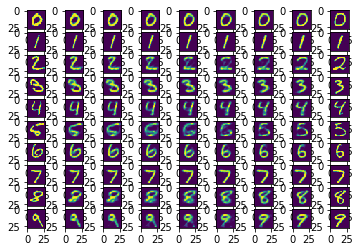

In [9]:
similar_pairs = {}
for _, (x, y) in enumerate(test_loader):
    for i in range(len(y)):
        if y[i].item() not in similar_pairs:
            similar_pairs[y[i].item()] = []
        if len(similar_pairs[y[i].item()])<2:
            similar_pairs[y[i].item()].append(x[i])
  
    done = True
    for i in range(10):
        if i not in similar_pairs or len(similar_pairs[i])<2:
            done = False
  
    if done:
        break
# similar_pairs[i] contains two images indexed at 0 and 1 that have images of the digit i
plt.figure(1)
for i in range(10):
    plt.subplot(10,9,i*9+1)
    plt.imshow(similar_pairs[i][0].reshape(28,28))
    images_new = create_interpolates(similar_pairs[i][0],similar_pairs[i][1], vae)
    for j in range(7):
        plt.subplot(10,9,i*9+1+j+1)
        plt.imshow(images_new[j].reshape(28,28).detach())
    plt.subplot(10,9,i*9+9)
    plt.imshow(similar_pairs[i][1].reshape(28,28))
plt.show()   

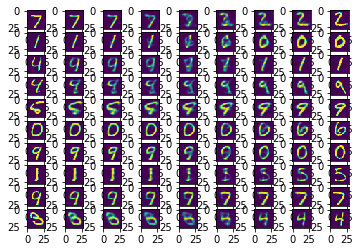

In [10]:
random_pairs = {}
for _, (x, y) in enumerate(test_loader):
  # Make sure the batch size is greater than 20
    for i in range(10):
        random_pairs[i] = []
        random_pairs[i].append(x[2*i])
        random_pairs[i].append(x[2*i+1])
    break
# random_pairs[i] contains two images indexed at 0 and 1 that are chosen at random

plt.figure(1)
for i in range(10):
    plt.subplot(10,9,i*9+1)
    plt.imshow(random_pairs[i][0].reshape(28,28))
    images_new = create_interpolates(random_pairs[i][0],random_pairs[i][1], vae)
    for j in range(7):
        plt.subplot(10,9,i*9+1+j+1)
        plt.imshow(images_new[j].reshape(28,28).detach())
    plt.subplot(10,9,i*9+9)
    plt.imshow(random_pairs[i][1].reshape(28,28))
plt.show() 

In [14]:
class VAE_CNN(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super(VAE_CNN, self).__init__() 
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=6, stride=2)
        # Hidden dim < 864 
        # 864 = (1+(28-6)/2)^2*6
        self.fc1 = nn.Linear(864, self.hidden_dim)
        self.fc21 = nn.Linear(self.hidden_dim, self.latent_dim)
        self.fc22= nn.Linear(self.hidden_dim, self.latent_dim)     
        self.fc3= nn.Linear(self.latent_dim, self.hidden_dim) 
        self.fc4= nn.Linear(self.hidden_dim, 864) 
        self.deconv1= nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=6, stride=2)
    
    def encoder(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 864)
        x = F.relu(self.fc1(x))
        x_mu = self.fc21(x)
        x_logvar = self.fc22(x)
        return x_mu, x_logvar
    
    def decoder(self, z):
        x = F.relu(self.fc3(z))
        # Binary entropy loss requires input between 0~1, hence uses sigmoid activation
        x = F.relu(self.fc4(x))
        x = x.view(-1, 6,12,12)
        x = F.sigmoid(self.deconv1(x))
        return x
    
    def forward(self, x):
        x_mu, x_logvar = self.encoder(x)
        z = self.sample(x_mu, x_logvar)
        x = self.decoder(z)
        return x, x_mu, x_logvar
    
    def sample(self,mu, logvar):
        std = torch.exp(0.5*logvar)
        return torch.randn_like(std).mul(std).add_(mu) 

In [15]:
vae_cnn = VAE_CNN(256,32)
optimizer = optim.Adam(vae_cnn.parameters(), lr=1e-3)
model_train_loss = train(vae_cnn, optimizer, train_loader, num_epochs = 10)

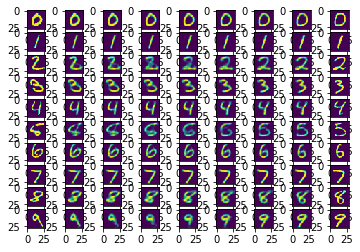

In [16]:
similar_pairs = {}
for _, (x, y) in enumerate(test_loader):
    for i in range(len(y)):
        if y[i].item() not in similar_pairs:
            similar_pairs[y[i].item()] = []
        if len(similar_pairs[y[i].item()])<2:
            similar_pairs[y[i].item()].append(x[i])
  
    done = True
    for i in range(10):
        if i not in similar_pairs or len(similar_pairs[i])<2:
            done = False
  
    if done:
        break
# similar_pairs[i] contains two images indexed at 0 and 1 that have images of the digit i
plt.figure(1)
for i in range(10):
    plt.subplot(10,9,i*9+1)
    plt.imshow(similar_pairs[i][0].reshape(28,28))
    images_new = create_interpolates(similar_pairs[i][0],similar_pairs[i][1], vae_cnn)
    for j in range(7):
        plt.subplot(10,9,i*9+1+j+1)
        plt.imshow(images_new[j].reshape(28,28).detach())
    plt.subplot(10,9,i*9+9)
    plt.imshow(similar_pairs[i][1].reshape(28,28))
plt.show()   

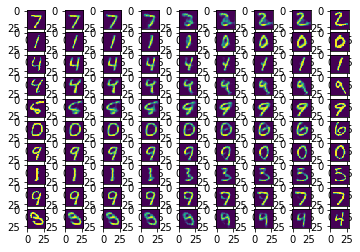

In [17]:
random_pairs = {}
for _, (x, y) in enumerate(test_loader):
  # Make sure the batch size is greater than 20
    for i in range(10):
        random_pairs[i] = []
        random_pairs[i].append(x[2*i])
        random_pairs[i].append(x[2*i+1])
    break
# random_pairs[i] contains two images indexed at 0 and 1 that are chosen at random

plt.figure(1)
for i in range(10):
    plt.subplot(10,9,i*9+1)
    plt.imshow(random_pairs[i][0].reshape(28,28))
    images_new = create_interpolates(random_pairs[i][0],random_pairs[i][1], vae_cnn)
    for j in range(7):
        plt.subplot(10,9,i*9+1+j+1)
        plt.imshow(images_new[j].reshape(28,28).detach())
    plt.subplot(10,9,i*9+9)
    plt.imshow(random_pairs[i][1].reshape(28,28))
plt.show() 